# Random Forests

Random forests are among the most widely used machine learning algorithm, probably
due to their relatively good performance "out of the box" and ease of use (not much
tuning required to get good results).

Random forests are an example of **ensemble methods**, meaning that it relies on aggregating the results of an ensemble of simpler classifiers. The idea behind ensemble method is that
***a majority vote among a number of weak classifiers can end up being a strong classifier.***

Random forests can also used for regression tasks.

* For classification tasks, the output of the random forest is the class selected by most trees. 

* For regression tasks, the mean or average prediction of the individual trees is returned.


## Ensemble Methods

Two most popular ensemble methods are bagging and boosting:

* **Bagging**: Training a bunch of individual models in a **parallel** way. Each model is trained by a random subset of the data.

* **Boosting**: Training a bunch of individual models in a **sequential** way. Each individual model learns from mistakes made by the previous model.

## Motivating Random Forests: Decision Trees

Random forest is an ensemble model using **bagging** as the ensemble method and **decision tree** as the individual model, but correct for decision trees' habit of overfitting to training data.

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero-in on the classification. For example, we can build a decision tree to classify an animal:

<img src='../figs/13_decision-tree.png'>

The binary splitting is extremely efficient. The trick comes in deciding which questions to ask at each step.
In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data: each node in the tree splits the data into two groups using a cutoff value within one of the features. 

Learning trees uses a top-down greedy algorithm. In this algorithm, we start from a single node. Then, we find out the threshold value which can reduce the uncertainty the most or yield the most **Information Gain**. We keep doing this until all rules are found out.

### Creating a decision tree

We begin with the standard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Consider the following two-dimensional data, which has one of four class labels:

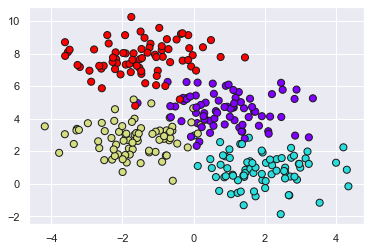

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow', edgecolor  = 'k');

A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it.
This figure presents a visualization of the first four levels of a decision tree classifier for this data:

![](figs/decision-tree-levels.png)

After the first split, every point in the upper branch remains unchanged, so there is no need to further subdivide this branch.
Except for nodes that contain all of one color, at each level *every* region is again split along one of the two features.

### Decision trees and over-fitting

This process of fitting a decision tree to our data can be done in Scikit-Learn with the ``DecisionTreeClassifier`` estimator:

In [3]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Let's write a quick utility function to help us visualize the output of the classifier:

In [4]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3, edgecolor = 'k')
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Now we can examine what the decision tree classification.

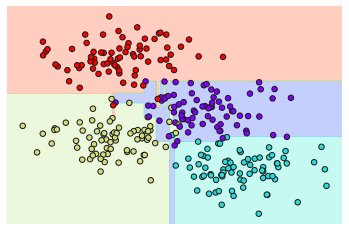

In [5]:
visualize_classifier(DecisionTreeClassifier(), X, y)

As the depth increases, we tend to get very strangely shaped classification regions; for example, at a depth of five, there is a tall and skinny purple region between the yellow and blue regions.
That is, this decision tree is clearly over-fitting our data.

**Over-fitting** turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from.

## Ensembles of Estimators: Random Forests

Multiple overfitting estimators can be combined to reduce the effect of this overfitting, which underlies an ensemble method called **bagging**.
Bagging makes use of an ensemble of parallel estimators, each of which over-fits the data, and averages the results to find a better classification.
An ensemble of randomized decision trees is known as a **random forest**. **Randomized decision trees** are models trained on a random subset of the data. **Random forests provides two dimensions of randomness** —first, with different observations and second, samplings of features.


![](figs/random-forests.png)


1. Select $n$ (e.g. 1000) random subsets from the training data.

2. Train $n$ decision trees **independently** on random subset of samples and/or on random subset of features.

3. Each tree predicts on new data individually.

4. The random forest predicts uses majority vote for classification, or uses the mean prediction of the trees for regression.


This type of bagging classification can be done manually using Scikit-Learn's ``BaggingClassifier`` meta-estimator, as shown here:

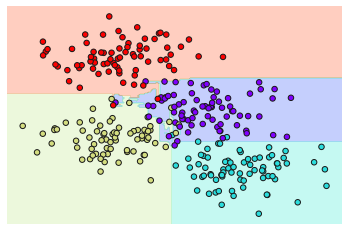

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

We have randomized the data by fitting each estimator with a random subset of 80% of the training points.
In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness.


In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the ``RandomForestClassifier`` estimator, which takes care of all the randomization automatically.
All you need to do is select a number of estimators, and it will very quickly fit the ensemble of trees:

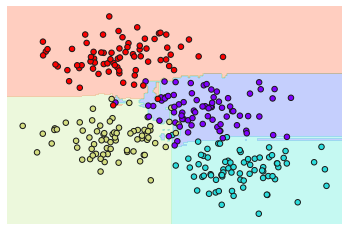

In [8]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0) 
visualize_classifier(model, X, y);

We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

## Random Forest Regression

Random forests can also be made to work in the case of regression (that is, continuous variables). The estimator to use for regression is the ``RandomForestRegressor``, and the syntax is very similar to what we saw earlier.



Consider the following synthetic data, drawn from the combination of a fast and slow oscillation:

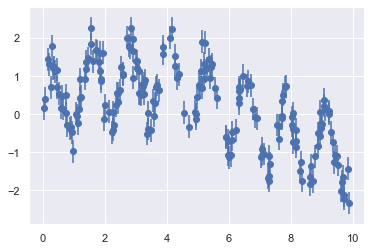

In [21]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Using the random forest regressor, we can find the best fit curve as follows:

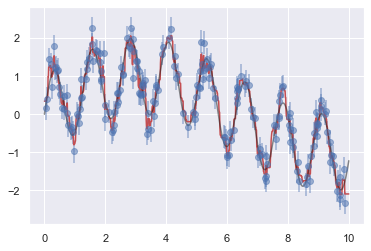

In [22]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators= 200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve.
As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without need to specifying a multi-period model.

## Example 1: Bicycle Traffic Prediction

The dataset was used for polynomial regression. We predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, holidays, and other factors.

Load the preprocessed data:

In [16]:
import pandas as pd

df = pd.read_csv('Bicycle_traffic_cleaned', index_col='Date', parse_dates=True)
df.head(10)

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.000000,0.1335,1.0
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.000000,0.1360,1.0
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.000000,0.1530,1.0
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.000000,0.1585,1.0
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.000000,0.1585,1.0
2012-10-08,7074.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.987503,0.000000,0.1445,1.0
2012-10-09,7002.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.929950,0.000000,0.1250,1.0
2012-10-10,6470.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.872560,0.000000,0.1025,1.0
2012-10-11,6094.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.815345,0.000000,0.1055,1.0


In [17]:
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)']
X = df[column_names]
y = df['Total']

print('Total number of days:', len(y))

Total number of days: 1064


In [18]:
X_train = X.iloc[:900]
X_test = X.iloc[900:]
y_train = y[:900]
y_test = y[900:]

daily_train = pd.DataFrame(y_train) # for plot
daily_test = pd.DataFrame(y_test) # for plot

In [23]:
forest = RandomForestRegressor(n_estimators=100, random_state=20).fit(X_train,y_train)

daily_train['predicted'] = forest.predict(X_train)
daily_test['predicted'] = forest.predict(X_test)

Predictions on Training data


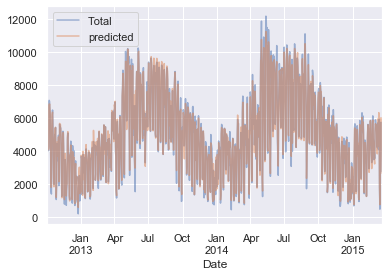

In [24]:
print('Predictions on Training data')
daily_train[['Total', 'predicted']].plot(alpha=0.5);

Predictions on Test data


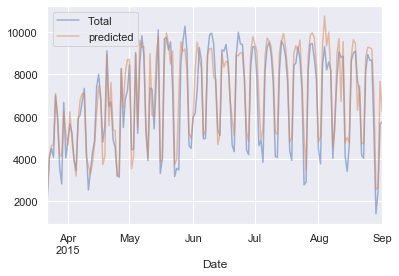

In [25]:
print('Predictions on Test data')
daily_test[['Total', 'predicted']].plot(alpha=0.5);

Check out the RMSE on training and test data:

In [26]:
from sklearn import metrics
print('Random Forests:')
print('Train RMSE:', np.sqrt(metrics.mean_squared_error(y_train, daily_train['predicted']) ))
print('Test RMSE:', np.sqrt(metrics.mean_squared_error(y_test, daily_test['predicted']) ))

Random Forests:
Train RMSE: 317.5504717888691
Test RMSE: 880.480261186487


#### Let's look at the decision tree regressor.

In [27]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor().fit(X_train,y_train)

daily_train['predicted'] = tree.predict(X_train)
daily_test['predicted'] = tree.predict(X_test)

Predictions on Training data


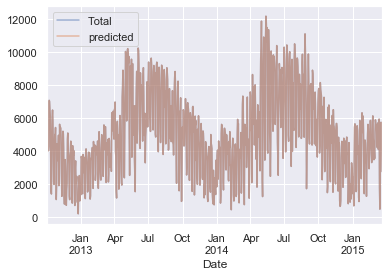

In [28]:
print('Predictions on Training data')

daily_train[['Total', 'predicted']].plot(alpha=0.5);

Predictions on Test data


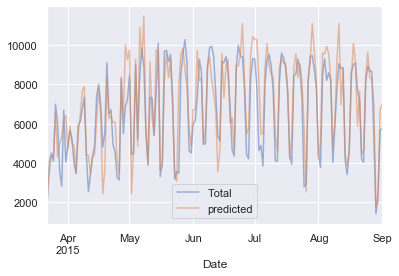

In [29]:
print('Predictions on Test data')
daily_test[['Total', 'predicted']].plot(alpha=0.5);

In [30]:
from sklearn import metrics
print('Decision Tree:')
print('Train RMSE:', np.sqrt(metrics.mean_squared_error(y_train, daily_train['predicted']) ))
print('Test RMSE:', np.sqrt(metrics.mean_squared_error(y_test, daily_test['predicted']) ))

Decision Tree:
Train RMSE: 0.0
Test RMSE: 1173.1174436455055


The traning error for decision tree is zero, but relatively large test error, which implies serious overfitting.

## Example 2: Random Forest for Classifying Digits

Earlier we took a quick look at the hand-written digits data.
Let's use that again here to see how the random forest classifier can be used in this context.

In [31]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

To remind us what we're looking at, we'll visualize the first few data points:

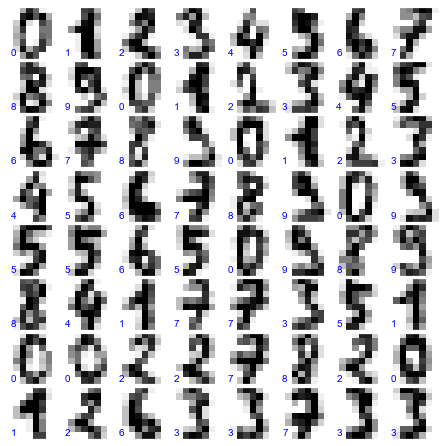

In [32]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]), color = 'blue')

We can quickly classify the digits using a random forest and a decision tree:

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)


model1 = RandomForestClassifier(n_estimators=1000).fit(Xtrain, ytrain)

model2 = DecisionTreeClassifier().fit(Xtrain, ytrain)

ypred1 = model1.predict(Xtest)
ypred2 = model2.predict(Xtest)

Use ``predict_proba()`` method to check the class probabilities given by the majority vote

In [34]:
print(model1.predict_proba(Xtest))
print()
print(model1.predict_proba(Xtest).shape)

[[0.002 0.019 0.852 ... 0.017 0.045 0.009]
 [0.01  0.055 0.068 ... 0.03  0.617 0.072]
 [0.001 0.003 0.976 ... 0.002 0.005 0.001]
 ...
 [0.002 0.006 0.003 ... 0.    0.013 0.063]
 [0.003 0.593 0.033 ... 0.017 0.235 0.005]
 [0.005 0.005 0.006 ... 0.001 0.011 0.839]]

(450, 10)


We can take a look at the classification report for the random forest:

In [35]:
from sklearn import metrics
print(metrics.classification_report(ypred1, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       1.00      0.98      0.99        44
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.98      0.98        48
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



And for good measure, plot the confusion matrix:

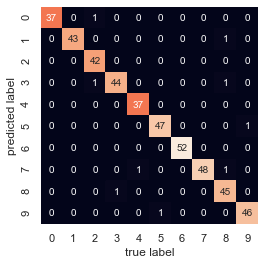

In [36]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred1)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

We find that random forest results in a very accurate classification of the digits data. Next, we check the performance of decision tree.

In [37]:
from sklearn import metrics
print(metrics.classification_report(ypred2, ytest))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90        36
           1       0.84      0.84      0.84        43
           2       0.82      0.78      0.80        46
           3       0.82      0.66      0.73        56
           4       0.87      0.92      0.89        36
           5       0.85      0.82      0.84        50
           6       0.94      0.98      0.96        50
           7       0.79      0.93      0.85        41
           8       0.81      0.87      0.84        45
           9       0.77      0.77      0.77        47

    accuracy                           0.84       450
   macro avg       0.84      0.85      0.84       450
weighted avg       0.84      0.84      0.84       450



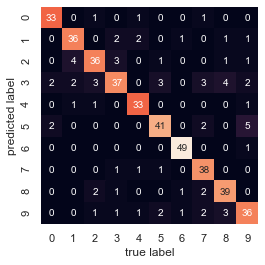

In [38]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Summary

Random forests are a powerful method with several advantages:

- Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be parallelized, because the individual trees are entirely independent entities.

- The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability, accessed in the ``predict_proba()`` method.

- The nonparametric model is extremely flexible, and can thus perform well on tasks that are under-fit by other estimators.

A primary disadvantage of random forests is that the results are not easily interpretable.